Installing the necessary packages

In [ ]:
#install required modules
!pip install -q geopandas
!pip install -q rasterio
!pip install -q geoplot

     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 16.7 MB 39.9 MB/s 
     |████████████████████████████████| 6.3 MB 41.7 MB/s 
     |████████████████████████████████| 19.3 MB 4.2 MB/s 
     |████████████████████████████████| 10.8 MB 9.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 48.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 28.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 37.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 44 kB 2.5 MB/s 


Importing the necessary packages and functions

In [ ]:
import rasterio as rio
from rasterio.plot import show, show_hist
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gpt
import pandas as pd
from shapely.geometry import Point
from shapely import wkt
import csv
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import joblib

Importing my google drive files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the 10m band data from the given files

In [ ]:
jp2s = ['/content/drive/MyDrive/Before_Files/BFR_B02.jp2','/content/drive/MyDrive/Before_Files/BFR_B03.jp2','/content/drive/MyDrive/Before_Files/BFR_B04.jp2','/content/drive/MyDrive/Before_Files/BFR_B08.jp2','/content/drive/MyDrive/After_Files/AFTR_B02.jp2','/content/drive/MyDrive/After_Files/AFTR_B03.jp2','/content/drive/MyDrive/After_Files/AFTR_B04.jp2','/content/drive/MyDrive/After_Files/AFTR_B08.jp2']
arrs = []

#Reads in 10m band images
for jp2 in jp2s:
    with rio.open(jp2) as f:
        arrs.append(f.read(1))

#Turns images into arrays
data = np.array(arrs, dtype=arrs[0].dtype)

BFR_B02 = np.array(data[0])
BFR_B03 = np.array(data[1])
BFR_B04 = np.array(data[2])
BFR_B08 = np.array(data[3])
AFTR_B02 = np.array(data[4])
AFTR_B03 = np.array(data[5])
AFTR_B04 = np.array(data[6])
AFTR_B08 = np.array(data[7])



RasterioIOError: ignored

Making a mask to isolate forests

In [ ]:
#Green mask removes vegetation that is too green, as forests are generally darker in colour. Masks by multiplying by 1 or 0.
def Green_Mask(input, threshold):
  input[input > threshold] = 0
  input[input != 0] = 1
  return input

#Removes all values not high enough in NDVI (not plant enough)
def NDVI_Mask(input, threshold):
  input[input <= threshold] = 0
  input[pd.isna(input)] = 0
  return input

green = Green_Mask(BFR_B03, 350)

#Calculates NDVI and multiplies by green mask
BFR_NDVI = np.multiply((BFR_B08.astype(float)-BFR_B04.astype(float))/(BFR_B08.astype(float)+BFR_B04.astype(float)), green.astype(float))
np.stack(BFR_NDVI)

Masked = NDVI_Mask(BFR_NDVI, 0.85)

#Plots the Vegetation
plt.figure(figsize = (20,20))
plt.imshow(Masked*200, cmap = 'gray', interpolation='nearest')
plt.savefig('Masked.png',dpi = 'figure')

Making a CSV of the of the bands without the ones covered by the mask

In [ ]:
#Creates a .csv file containing all the points that contain forest, and the band data for each of those pixels (point = pixel)
def CSV_Maker(BFR_B02,BFR_B03,BFR_B04,BFR_B08,AFTR_B02,AFTR_B03,AFTR_B04,AFTR_B08,NDVI):
  geometry = []
  row_length = len(BFR_B02[0])
  counter = 0
  row_counter = 0
  new_BFR_B02 = []
  new_BFR_B03 = []
  new_BFR_B04 = []
  new_BFR_B08 = []
  new_AFTR_B02 = []
  new_AFTR_B03 = []
  new_AFTR_B04 = []
  new_AFTR_B08 = []
  for j in range(len(BFR_B02)):
    for i in range(len(BFR_B02)):
      if NDVI[j,i] != 0:
        geometry.append(Point(i,j))
        new_BFR_B02.append(BFR_B02[j,i])
        new_BFR_B03.append(BFR_B03[j,i])
        new_BFR_B04.append(BFR_B04[j,i])
        new_BFR_B08.append(BFR_B08[j,i])
        new_AFTR_B02.append(AFTR_B02[j,i])
        new_AFTR_B03.append(AFTR_B03[j,i])
        new_AFTR_B04.append(AFTR_B04[j,i])
        new_AFTR_B08.append(AFTR_B08[j,i])
  columns = [new_BFR_B02,new_BFR_B03,new_BFR_B04,new_BFR_B08,new_AFTR_B02,new_AFTR_B03,new_AFTR_B04,new_AFTR_B08]
  data = {'BFR_B02':columns[0],'BFR_B03':columns[1],'BFR_B04':columns[2],'BFR_B08':columns[3],'AFTR_B02':columns[4],'AFTR_B03':columns[5],'AFTR_B04':columns[6],'AFTR_B08':columns[7],'geometry':geometry}
  df = pd.DataFrame(data)
  return df.to_csv('forest_data_Final.csv')

Running the CSV maker

In [ ]:
arr = data
NDVI = Masked

CSV_Maker(arr[0],arr[1],arr[2],arr[3],arr[4],arr[5],arr[6],arr[7],NDVI)

Teaching the machine learning algorithm

In [ ]:
Data = gpd.read_file("/content/drive/MyDrive/Training_Data.csv")
Data = Data[['ArwenDamage','BFR_B02','BFR_B03','BFR_B04','BFR_B08','AFTR_B02','AFTR_B03','AFTR_B04','AFTR_B08']]
X = Data.drop(columns=['ArwenDamage'])
y= Data['ArwenDamage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
joblib.dump(clf, 'Damage_Tester_Tree_v1.1.joblib')

ERROR:fiona._env:/content/drive/MyDrive/Training_Data.csv: No such file or directory


DriverError: ignored

In [ ]:
File_read = pd.read_csv("/content/drive/MyDrive/forest_data_Final.csv")
File_read = File_read[['BFR_B02','BFR_B03','BFR_B04','BFR_B08','AFTR_B02','AFTR_B03','AFTR_B04','AFTR_B08']]

model = joblib.load('/content/drive/MyDrive/Damage_Tester_MLP_v1.1.joblib')

Prediction = []
for i in range(len(File_read)):
  test = File_read.iloc[i]
  test = np.array(test)
  test = test.reshape(1,-1)
  pred = model.predict(test)
  pred = pred[0]
  Prediction.append(pred)

Final_data = pd.read_csv("/content/drive/MyDrive/forest_data_Final.csv")
Final_data['Damage'] = Prediction
Final_data.to_csv('Final_Data_2.csv')

Below we plotted the points that where effected by the forest and those that were not

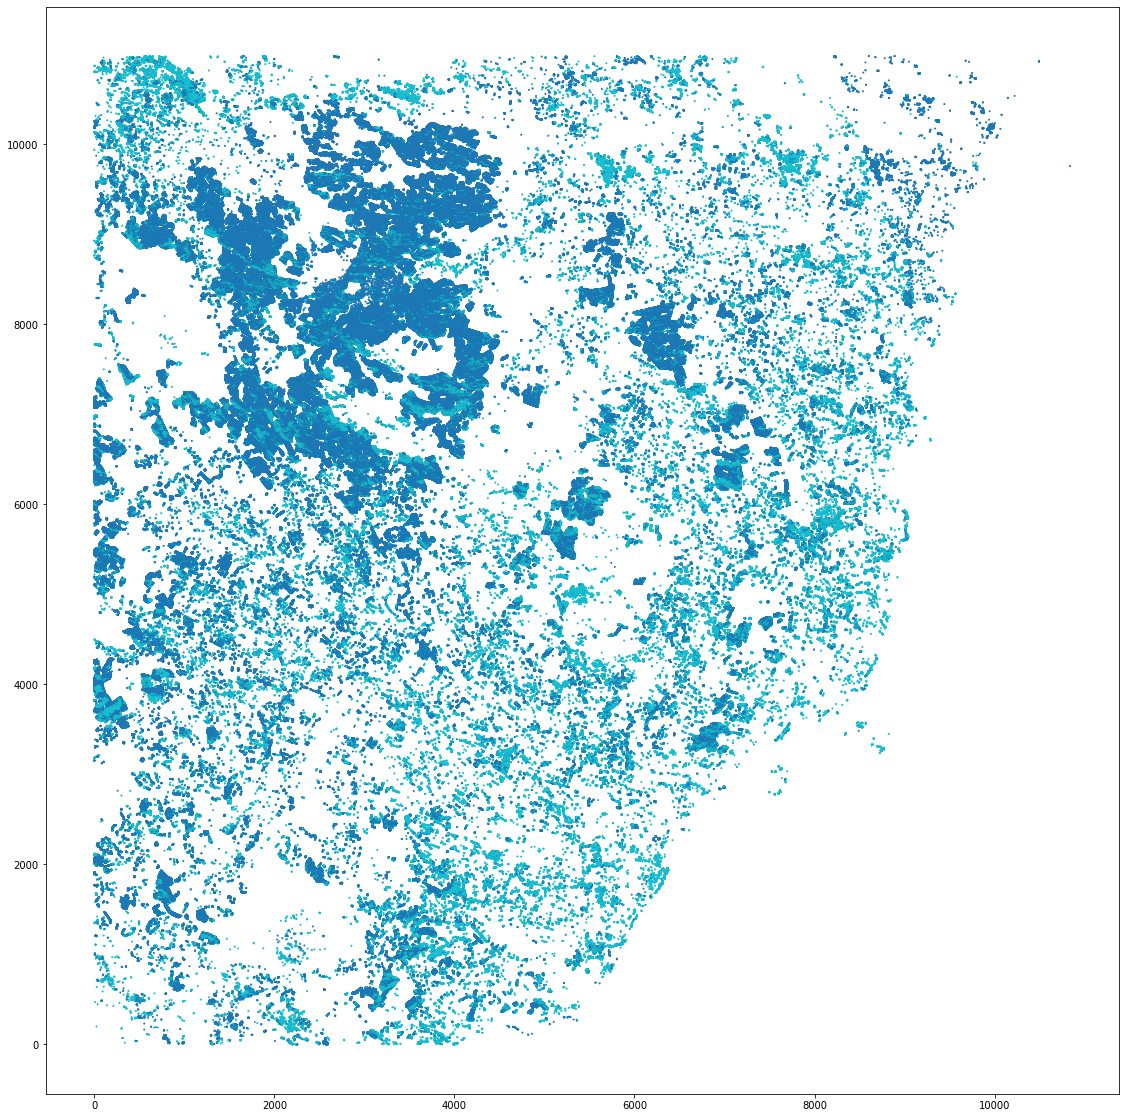

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Final_Data_2.csv')

data['geometry'] = data['geometry'].apply(wkt.loads)

crs = "epsg:3857"
points = gpd.GeoDataFrame(data, geometry = 'geometry')
points.plot(column = 'Damage', figsize=(20,20), markersize = 1)

Below we stacked the bands for red, green and blue and attempted to add the image containing the areas of interest and how affected they were. However, this did not work, it is an issue that was partly fixed, but we sadly ran out of time to complete the debugging.

In [ ]:
B01 = '/content/1830*1830_Masked.jp2'
B02 = '/content/drive/MyDrive/KCL_Hackathon_GSI_Challenge_Data.zip (Unzipped Files)/S2A_MSIL2A_20211110T112311_N0301_R037_T30UWG_20211110T142043.SAFE/GRANULE/L2A_T30UWG_A033353_20211110T112451/IMG_DATA/R60m/AFTR_B02_60.jp2'
B03 = '/content/drive/MyDrive/KCL_Hackathon_GSI_Challenge_Data.zip (Unzipped Files)/S2A_MSIL2A_20211110T112311_N0301_R037_T30UWG_20211110T142043.SAFE/GRANULE/L2A_T30UWG_A033353_20211110T112451/IMG_DATA/R60m/AFTR_B03_60.jp2'
B04 = '/content/drive/MyDrive/KCL_Hackathon_GSI_Challenge_Data.zip (Unzipped Files)/S2A_MSIL2A_20211110T112311_N0301_R037_T30UWG_20211110T142043.SAFE/GRANULE/L2A_T30UWG_A033353_20211110T112451/IMG_DATA/R60m/AFTR_B04_60.jp2'

with rio.open(B01) as src:
  a = src.read(1)

with rio.open(B02) as src:
  b = src.read(1)

with rio.open(B03) as src:
  c= src.read(1)

with rio.open(B04) as src:
  d = src.read(1)

A= prepare(a)
B= prepare(b)
C = prepare(c)
D = prepare(d)

fig, ax_image = plt.subplots(figsize=(15, 15))

stack = np.stack([A, B, C, D])

open(B01)
open(B02)
open(B03)
open(B04)

show(stack, transform=src.profile['transform'], ax=ax_image)

ax_image.tick_params(axis='both', which='major', labelsize=16)

ax_image.set_xlabel('Easting (m)', fontsize=18)
ax_image.set_ylabel('Northing (m)', fontsize=18)

ax_image.set_title('S2 RGB Composite\n11th Feb 2021 - Tile 30VVH', fontsize=20)


